# Handwritten Digit Recognition
Learning algorithms for the classification of handwritten digits.

This notebook uses the MNIST digits dataset to train two different supervised learning models for the classification of handwritten digits. First we'll train a Linear Support Vector Machine for classification (SVC) model using LinearSVC from sci-kit learn. Then we'll build and compile a Convolutional Neural Network (CNN) model using a sequential model from TensorFlow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import idx2numpy

from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

## MNIST digits dataset

The MNIST database (Modified National Institute of Standards and Technology database) is a large collection of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger NIST Special Database 3 (digits written by employees of the United States Census Bureau) and Special Database 1 (digits written by high school students) which contain monochrome images of handwritten digits. The digits have been size-normalized and centered in a fixed-size image. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

source: http://yann.lecun.com/exdb/mnist/index.html

In [2]:
# dataset files are in idx format
idx_files = ["train-images-idx3-ubyte", "train-labels-idx1-ubyte", "t10k-images-idx3-ubyte",  "t10k-labels-idx1-ubyte"]

In [3]:
# use idx2numpy to read idx files
def read_idx(idx_file):
    f_read = open(idx_file, 'rb')
    ndarr = idx2numpy.convert_from_file(f_read)
    return ndarr

In [4]:
train_images = read_idx(idx_files[0])
train_labels = read_idx(idx_files[1])
test_images = read_idx(idx_files[2])
test_labels = read_idx(idx_files[3])

In [5]:
# check dataset shape
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

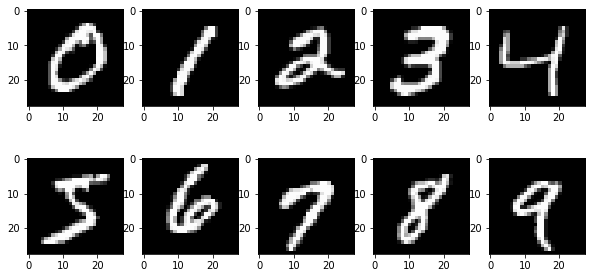

In [30]:
# plot one example of each digit (class)
plt.figure(figsize=(10,5))
count=1
for i in range(10):
    idx = np.argwhere(train_labels==i)[0]
    img = train_images[idx].reshape(28,28,1)
    ax = plt.subplot(2,5,count)
    count+=1
    plt.imshow(img, cmap="gray")
plt.show()

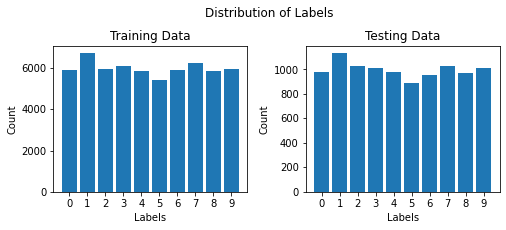

In [7]:
# plot the distribution of class labels in the training and testing datasets
training_labels_counts = pd.Series(train_labels).value_counts().sort_index()
testing_labels_counts = pd.Series(test_labels).value_counts().sort_index()
title = ["Training Data", "Testing Data"]
count=0
plt.figure(figsize=(8,3))
for labels_counts in [training_labels_counts, testing_labels_counts]:
    ax = plt.subplot(1,2,count+1)
    plt.bar(labels_counts.index, labels_counts.values)
    plt.title(title[count])
    plt.xlabel("Labels")
    plt.ylabel("Count")
    ax.set_xticks(labels_counts.index)
    count+=1
    plt.subplots_adjust(hspace=0.5, wspace=0.3, top=0.8)

plt.suptitle("Distribution of Labels")
plt.show()

In [8]:
# compute weights for class labels
class_labels = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_labels)
class_weights = dict(zip(class_labels, class_weights))
class_weights

{0: 1.0130001688333614,
 1: 0.8899436369029962,
 2: 1.0070493454179255,
 3: 0.978633175664655,
 4: 1.0270455323519343,
 5: 1.1068068622025458,
 6: 1.013856032443393,
 7: 0.9577015163607342,
 8: 1.025465732353444,
 9: 1.0085728693898135}

## Supervised Learning Models

### Support Vector Machines (SVM) Model

Train a Linear Support Vector Classification (Linear SVC) model with hyperparameter tuning using scikit-learn GridSearchCV

In [9]:
# scale image data from 0-255 to 0-1 with sklearn Normalizer
scaler = Normalizer()
scaled_train_images = scaler.fit_transform(train_images.reshape(-1,28*28))
scaled_test_images = scaler.transform(test_images.reshape(-1,28*28))

In [10]:
model_scv = LinearSVC(max_iter=10000)

param_grid_svc = {
    'penalty':['l2'],
    'C':[1.0, 2.0],
    'class_weight':[None, 'balanced'],
    'tol':[0.0001, 0.01],
    'random_state':[123],
    'max_iter':[10000],
    'dual':[True],
    'loss':['hinge', 'squared_hinge']
}

grid = GridSearchCV(
    model_scv,
    param_grid=param_grid_svc,
    cv=3,
    verbose=1,
    scoring=None
)

grid.fit(scaled_train_images, train_labels)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=LinearSVC(max_iter=10000),
             param_grid={'C': [1.0, 2.0], 'class_weight': [None, 'balanced'],
                         'dual': [True], 'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [10000], 'penalty': ['l2'],
                         'random_state': [123], 'tol': [0.0001, 0.01]},
             verbose=1)

In [11]:
# best parameters found by gridsearch
grid.best_params_

{'C': 2.0,
 'class_weight': 'balanced',
 'dual': True,
 'loss': 'hinge',
 'max_iter': 10000,
 'penalty': 'l2',
 'random_state': 123,
 'tol': 0.01}

In [12]:
# results from gridsearch
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score", ascending=True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_dual,param_loss,param_max_iter,param_penalty,param_random_state,param_tol,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,3.222942,0.191387,0.031665,0.000517,2.0,balanced,True,hinge,10000,l2,123,0.01,"{'C': 2.0, 'class_weight': 'balanced', 'dual':...",0.91510,0.91215,0.91815,0.915133,0.002450,1
12,5.109109,0.115156,0.031328,0.000466,2.0,balanced,True,hinge,10000,l2,123,0.0001,"{'C': 2.0, 'class_weight': 'balanced', 'dual':...",0.91485,0.91210,0.91825,0.915067,0.002515,2
9,3.286841,0.192208,0.030409,0.000985,2.0,None,True,hinge,10000,l2,123,0.01,"{'C': 2.0, 'class_weight': None, 'dual': True,...",0.91460,0.91180,0.91795,0.914783,0.002514,3
14,5.462653,0.059372,0.031156,0.000206,2.0,balanced,True,squared_hinge,10000,l2,123,0.0001,"{'C': 2.0, 'class_weight': 'balanced', 'dual':...",0.91335,0.91245,0.91855,0.914783,0.002689,3
15,4.303101,0.126747,0.032130,0.001052,2.0,balanced,True,squared_hinge,10000,l2,123,0.01,"{'C': 2.0, 'class_weight': 'balanced', 'dual':...",0.91315,0.91250,0.91865,0.914767,0.002759,5


#### SVC Model Metrics

In [13]:
# predict class labels for the test dataset

predicted_classes_svc = grid.predict(scaled_test_images)

In [14]:
# print scores using sklearn classification report and confusion matrix

def print_metrics(target_labels, predicted_labels):
    report = classification_report(target_labels, predicted_labels)
    print("\nClassification Report:\n\n", report)   
    cm = confusion_matrix(target_labels, predicted_labels)
    print("\nConfusion Matrix:\n\n", cm)
    
# print_metrics(test_labels, predicted_classes_svc)

In [15]:
grid.score(scaled_test_images, test_labels)

0.9216

### Convolutional Neural Network (CNN) Model
Let's use Tensorflow to build, compile, and train a sequential model with mutilple convolution layers for multi-class classification.



In [16]:
train_images.shape

(60000, 28, 28)

Convert the training labels to a binary matrix using keras utility `to_categorical`

In [17]:
y = pd.DataFrame(tf.keras.utils.to_categorical(train_labels))
y.head()


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Build and compile the model
Build a convolutional neural network (CNN) with Conv2D and pooling layers.

Model inspired by the paper, "An Ensemble of Simple Convolutional Neural Network Models for MNIST Digit Recognition
" - https://arxiv.org/abs/2008.10400

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

model_cnn = Sequential()
model_cnn.add(layers.InputLayer(input_shape=(28,28,1)))
model_cnn.add(layers.Rescaling(1.0/255))

model_cnn.add(layers.Conv2D(28, (3,3), activation="relu"))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu"))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation="relu"))

model_cnn.add(layers.Dense(10,activation="softmax"))

model_cnn.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
   loss=tf.keras.losses.CategoricalCrossentropy(),
   metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        8096      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0

2022-11-14 14:04:19.877279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Train the model with early stopping and class weights

In [19]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.0001,
    monitor="val_auc",
    mode="max",
    patience=20,
    restore_best_weights=True
)
history = model_cnn.fit(
    train_images,
    y,
    batch_size=256,
    epochs=50,
    callbacks=[early_stopping],
    class_weight=class_weights,
    validation_data=(test_images, keras.utils.to_categorical(test_labels))
)

Epoch 1/50
235/235 [==============================] - 14s 56ms/step - loss: 1.3422 - categorical_accuracy: 0.7088 - auc: 0.9295 - val_loss: 0.4882 - val_categorical_accuracy: 0.8817 - val_auc: 0.9890
Epoch 2/50
235/235 [==============================] - 13s 55ms/step - loss: 0.3666 - categorical_accuracy: 0.9007 - auc: 0.9921 - val_loss: 0.2669 - val_categorical_accuracy: 0.9245 - val_auc: 0.9946
Epoch 3/50
235/235 [==============================] - 13s 56ms/step - loss: 0.2502 - categorical_accuracy: 0.9282 - auc: 0.9950 - val_loss: 0.2058 - val_categorical_accuracy: 0.9380 - val_auc: 0.9964
Epoch 4/50
235/235 [==============================] - 13s 57ms/step - loss: 0.1997 - categorical_accuracy: 0.9425 - auc: 0.9964 - val_loss: 0.1673 - val_categorical_accuracy: 0.9503 - val_auc: 0.9972
Epoch 5/50
235/235 [==============================] - 13s 56ms/step - loss: 0.1682 - categorical_accuracy: 0.9510 - auc: 0.9972 - val_loss: 0.1448 - val_categorical_accuracy: 0.9584 - val_auc: 0.9977


#### Plot auc and accuracy of the trained model

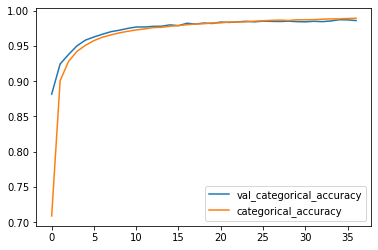

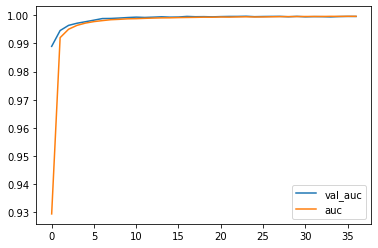

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['val_categorical_accuracy', 'categorical_accuracy']].plot();
history_df.loc[:, ['val_auc', 'auc']].plot();

#### CNN Model Metrics

In [21]:
# predict the class labels for the test dataset using the cnn model
predicted_classes_cnn = np.argmax(model_cnn.predict(test_images), axis=1)

313/313 [==============================] - 1s 2ms/step


In [22]:
print_metrics(test_labels, predicted_classes_cnn)


Classification Report:

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Confusion Matrix:

 [[ 968    0    4    0    0    0    4    2    2    0]
 [   0 1127    2    1    0    0    2    0    3    0]
 [   2    3 1015    1    2    1    0    4    4    0]
 [   0    0    3  992    0    6    

In [23]:
accuracy_score(test_labels, predicted_classes_cnn)

0.9823

#### Save the model

In [28]:
model_cnn.save('saved_model/handwritten_digits_cnn')

INFO:tensorflow:Assets written to: saved_model/handwritten_digits_cnn/assets


INFO:tensorflow:Assets written to: saved_model/handwritten_digits_cnn/assets


#### Plot the predictions

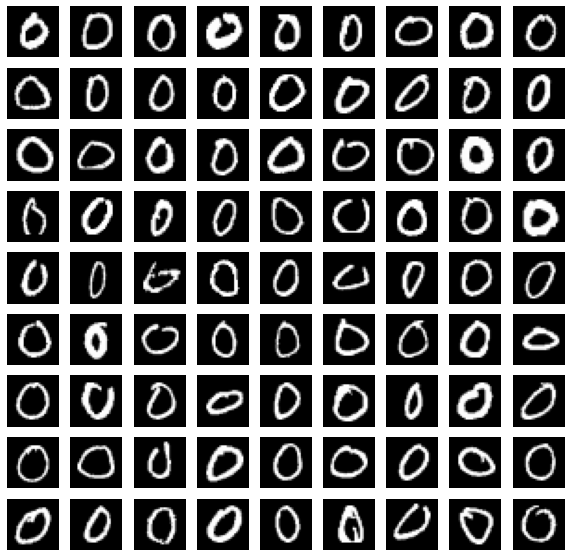

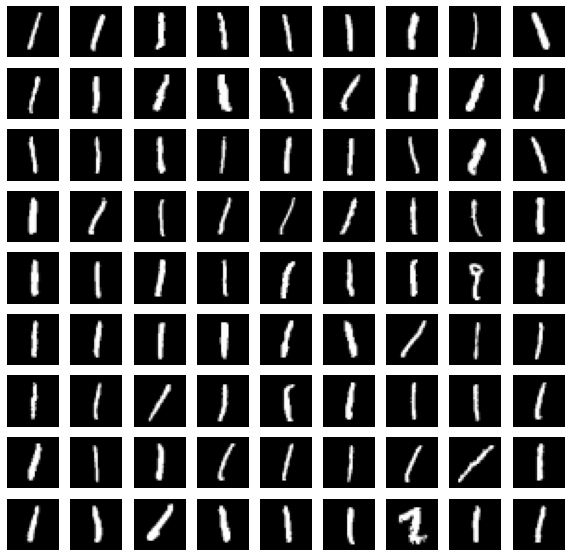

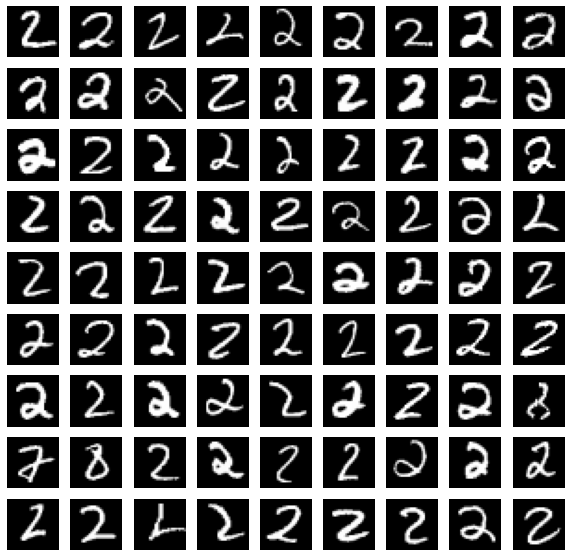

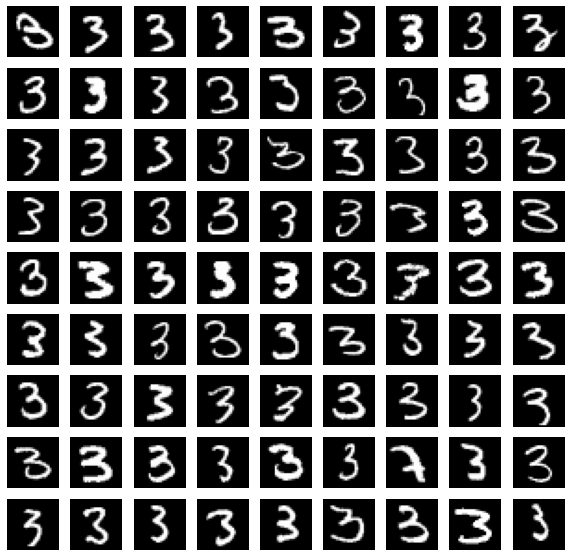

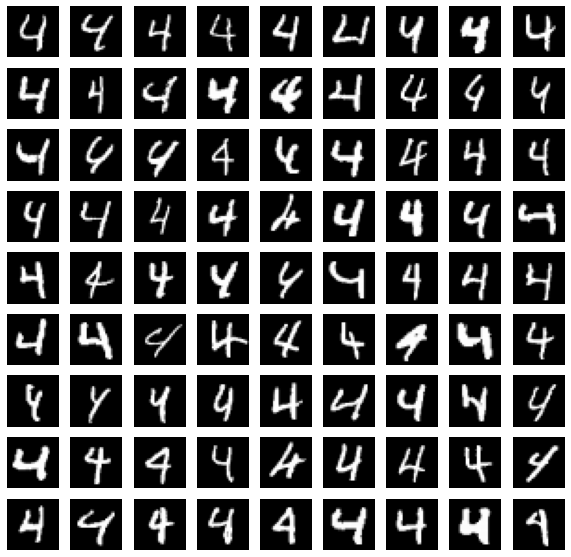

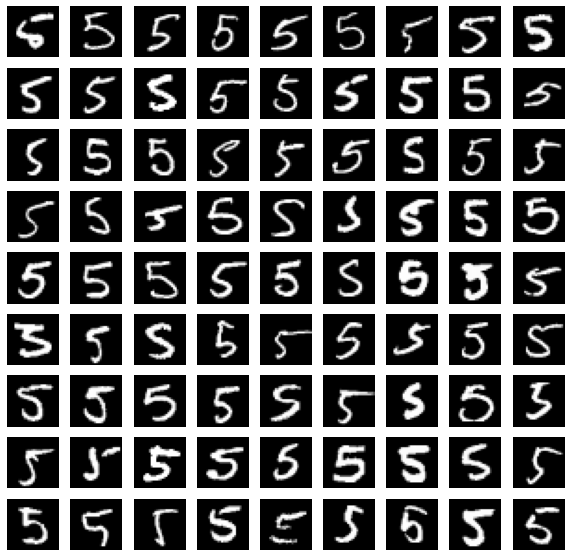

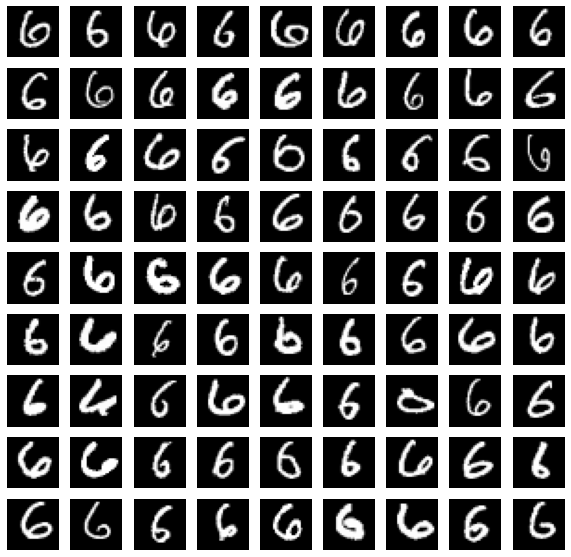

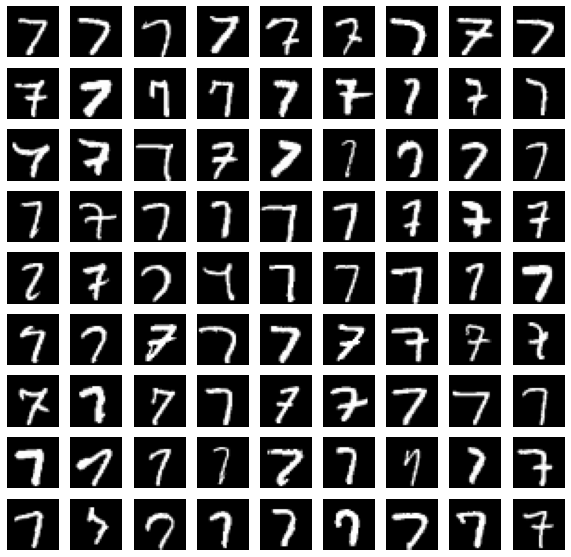

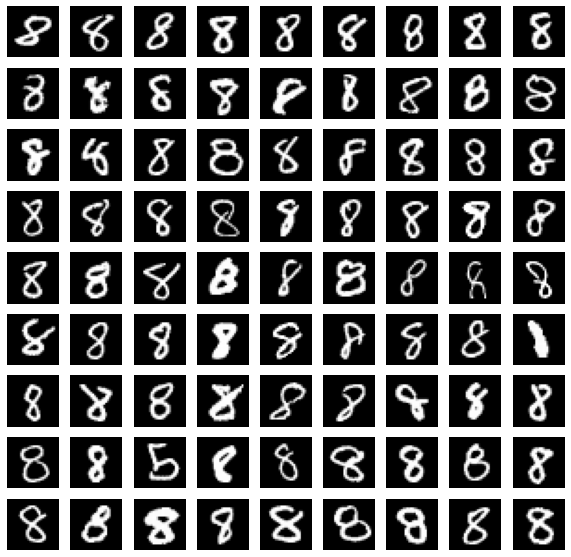

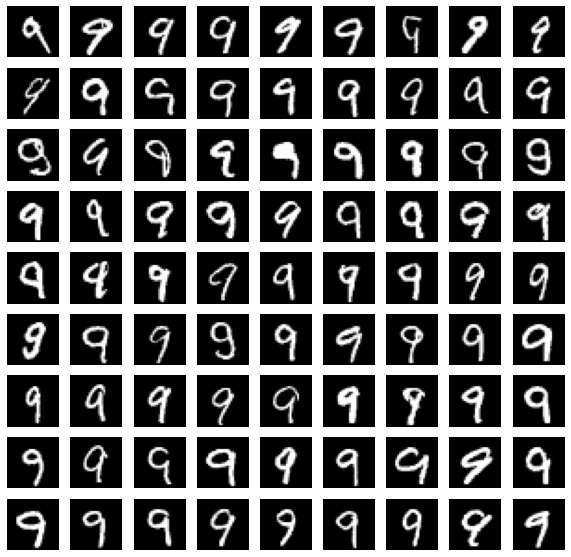

In [29]:
# plot a 9x9 grid of each class label from the testing data predictions from each model
def plot_compare_model_predictions(model_predictions, i):
    plt.figure(figsize=(10,10))
    count=1
    for s in range(81):
        idx = np.argwhere(model_predictions==i)[s]
        img = test_images[idx].reshape(28,28,1)
        ax = plt.subplot(9,9,count)
        ax.axis("off")
        ax = plt.imshow(img, cmap="gray")
        count+=1
for i in range(10):
    plot_compare_model_predictions(predicted_classes_cnn, i)
    plt.show()